In [ ]:
# %pip install tensorflow
# %pip install --upgrade pip

In [1]:
import os
from google.colab import userdata
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# @title Load Dataset
kaggle_key = userdata.get('kaggle')

# Download latest version
path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to dataset files:", path)

100%|██████████| 6.70G/6.70G [05:24<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2


# Data Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.05), # +/- 5% rotation (approx 18 deg)
  tf.keras.layers.RandomZoom(0.1),      # +/- 10% zoom
  tf.keras.layers.RandomContrast(0.1)
])

def augment_minority(image, label):
    # Assume: 0=CNV (Major), 1=DME (Minor), 2=DRUSEN (Minor), 3=NORMAL (Major)
    
    # If label is DME (1) or DRUSEN (2), apply augmentation
    # NOTE: In TF, labels are tensors, use cond
    
    is_minority = tf.math.logical_or(label == 1, label == 2)
    
    image = tf.cond(
        is_minority,
        lambda: data_augmentation(image), # Apply aug if minority
        lambda: image                     # Return original if majority
    )
    return image, label

# Apply to dataset
train_ds = train_ds.map(augment_minority, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Download the content
for item in os.listdir(path):
    print(item)

### Training set

# # --- keras 3
# training_set = image_dataset_from_directory(
#     "dataset/Dataset - train+val+test/train",
#     labels="inferred", # label names inferred from dataset structure
#     label_mode="categorical", # catergories are CNV, DME, DRUSSEN, NORMAL << chnage with new categories
#     class_names=None,
#     color_mode="rgb",
#     batch_size=32,
#     image_size=(224, 224), # changed to fit MobileNet model
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation="bilinear",
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     pad_to_aspect_ratio=False,
#     data_format=None,
#     verbose=True,
# )

# --- keras 2
training_set = image_dataset_from_directory(
    f"{path}/Dataset - train+val+test/train",
    labels="inferred", # label names inferred from dataset structure
    label_mode="categorical", # catergories are CNV, DME, DRUSSEN, NORMAL << chnage with new categories
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224), # changed to fit MobileNet model
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Dataset - train+val+test
Found 76515 files belonging to 4 classes.


In [ ]:
### validation set
# --- keras 2
validation_set = image_dataset_from_directory(
    f"{path}/Dataset - train+val+test/val",
    labels="inferred", # label names inferred from dataset structure
    label_mode="categorical", # catergories are CNV, DME, DRUSSEN, NORMAL << chnage with new categories
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224), # changed to fit MobileNet model
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 21861 files belonging to 4 classes.


In [ ]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
INPUT_SHAPE = (224,224,3)

# Model Training

In [ ]:
## Model Training
mobnet = tf.keras.applications.MobileNetV3Large(
    input_shape=INPUT_SHAPE,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True
    # name="MobileNetV3Large",
)

In [ ]:
#@title ##### Transfer learning
# mobnet.trainable = False # freeze pretrained layer, best if low training data

In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
model.add(tf.keras.Input(shape=INPUT_SHAPE))

In [ ]:
model.add(mobnet)

In [ ]:
model.add(tf.keras.layers.Dense(units = 4, activation="softmax"))

In [ ]:
metrics_list = ["accuracy", tf.keras.metrics.F1Score()] # monitor model performance

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=metrics_list)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 1000)           │     5,507,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,511,436 (21.02 MB)

 Trainable params: 5,487,036 (20.93 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [ ]:
training_history = model.fit(x=training_set, validation_data=validation_set, epochs=15)

Epoch 1/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 225s 60ms/step - accuracy: 0.8542 - f1_score: 0.6371 - loss: 1.2294 - val_accuracy: 0.8992 - val_f1_score: 0.6951 - val_loss: 0.9766
Epoch 2/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.8931 - f1_score: 0.6901 - loss: 0.9165 - val_accuracy: 0.8962 - val_f1_score: 0.7005 - val_loss: 0.7308
Epoch 3/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.8935 - f1_score: 0.6989 - loss: 0.6861 - val_accuracy: 0.9040 - val_f1_score: 0.7031 - val_loss: 0.5575
Epoch 4/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.9579 - f1_score: 0.9250 - loss: 0.5254 - val_accuracy: 0.9548 - val_f1_score: 0.9247 - val_loss: 0.4395
Epoch 5/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - accuracy: 0.9628 - f1_score: 0.9355 - loss: 0.4107 - val_accuracy: 0.9651 - val_f1_score: 0.9389 - val_loss: 0.3443
Epoch 6/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.9679 - f1_score: 0.9446 - loss: 0.3204 - val_accuracy: 0.96

In [4]:
save_path = "/content/drive/MyDrive/Colab Notebooks/Eye-Disease"

In [ ]:
model.save(f"{save_path}/Trained_Eye_disease_model.h5")
model.save(f"{save_path}/Trained_Eye_disease_model.keras")

In [ ]:
training_history.history

{'accuracy': [0.8819447159767151,
  0.8930667042732239,
  0.8940730690956116,
  0.9607920050621033,
  0.965157151222229,
  0.9695354104042053,
  0.9728288650512695,
  0.9766712188720703,
  0.9806966185569763,
  0.9832320213317871,
  0.9852578043937683,
  0.9867869019508362,
  0.9883291125297546,
  0.9891393780708313,
  0.9905508756637573],
 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.88886184, 0.8488561 , 0.00414342, 0.9579942 ], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.92544514, 0.90546954, 0.        , 0.9400826 ], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.95401746, 0.9269082 , 0.        , 0.91780937], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9668091 , 0.9399062 , 0.8342518 , 0.98240614], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.96988356, 0.9476604 , 0.8543057 , 0.984514  ], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy

In [ ]:
# Save History
import pickle
with open(f"{save_path}/Training_history.pkl", "wb") as f:
    pickle.dump(training_history.history, f)

# Model Evaluation

In [5]:
model = tf.keras.models.load_model(f"{save_path}/Trained_Eye_disease_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 178 variables whereas the saved optimizer has 354 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
import pickle
with open(f"{save_path}/Training_history.pkl", "rb") as f:
    load_history = pickle.load(f)
print(load_history)

{'accuracy': [0.8819447159767151, 0.8930667042732239, 0.8940730690956116, 0.9607920050621033, 0.965157151222229, 0.9695354104042053, 0.9728288650512695, 0.9766712188720703, 0.9806966185569763, 0.9832320213317871, 0.9852578043937683, 0.9867869019508362, 0.9883291125297546, 0.9891393780708313, 0.9905508756637573], 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.88886184, 0.8488561 , 0.00414342, 0.9579942 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.92544514, 0.90546954, 0.        , 0.9400826 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.95401746, 0.9269082 , 0.        , 0.91780937], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9668091 , 0.9399062 , 0.8342518 , 0.98240614], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.96988356, 0.9476604 , 0.8543057 , 0.984514  ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9746474, 0.9549839, 0.8726687

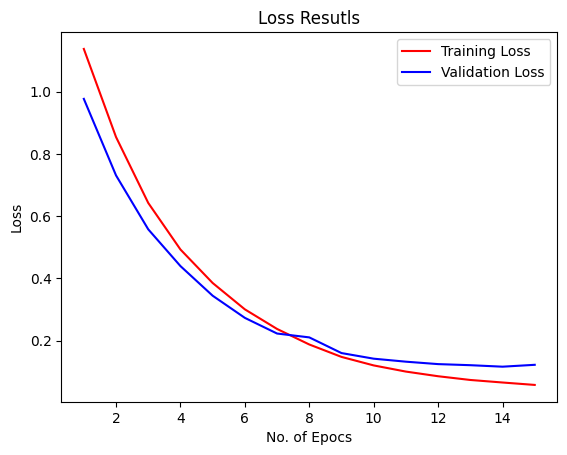

In [7]:
epochs = [i for i in range(1,16)]
plt.plot(epochs, load_history['loss'], color='red', label='Training Loss')
plt.plot(epochs, load_history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel("No. of Epocs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Resutls")
plt.show()

In [8]:
model = tf.keras.models.load_model(f"{save_path}/Trained_Eye_disease_model.keras")

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 1000)           │     5,507,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,998,474 (41.96 MB)

 Trainable params: 5,487,036 (20.93 MB)

 Non-trainable params: 24,400 (95.31 KB)

 Optimizer params: 5,487,038 (20.93 MB)

In [24]:
### TEST set
test_set = image_dataset_from_directory(
    f"{path}/Dataset - train+val+test/val",
    labels="inferred", # label names inferred from dataset structure
    label_mode="categorical", # catergories are CNV, DME, DRUSSEN, NORMAL << chnage with new categories
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224), # changed to fit MobileNet model
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 21861 files belonging to 4 classes.


In [25]:
test_loss, test_acc, f1_score = model.evaluate(test_set)

684/684 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9654 - f1_score: 0.6346 - loss: 0.1344


In [26]:
test_loss, test_acc, f1_score

(0.12232951819896698,
 0.9704039096832275,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.97357416, 0.94445616, 0.89126146, 0.9876877 ], dtype=float32)>)

In [27]:
#Compute True lable from test set
true_categories = tf.concat([y for x,y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [28]:
true_categories

<tf.Tensor: shape=(21861, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)>

In [29]:
Y_true

<tf.Tensor: shape=(21861,), dtype=int64, numpy=array([0, 0, 0, ..., 3, 3, 3])>

In [30]:
from numpy import permute_dims
# Compute predicted lables using test_set
predicted_categories = model.predict(test_set)
predicted_categories

684/684 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


array([[0.98464173, 0.00416856, 0.0063707 , 0.00481904],
       [0.9846421 , 0.00416818, 0.00637074, 0.00481905],
       [0.6969666 , 0.04579739, 0.18882325, 0.06841274],
       ...,
       [0.00301018, 0.00373861, 0.00535298, 0.9878982 ],
       [0.00301018, 0.00373861, 0.00535301, 0.9878982 ],
       [0.00416741, 0.00475651, 0.00844165, 0.98263437]], dtype=float32)

In [31]:
Y_pred = tf.argmax(predicted_categories, axis=1)
Y_pred

<tf.Tensor: shape=(21861,), dtype=int64, numpy=array([0, 0, 0, ..., 3, 3, 3])>

# Classification Report

In [34]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7491
           1       0.93      0.96      0.94      2319
           2       0.89      0.89      0.89      1773
           3       0.98      0.99      0.99     10278

    accuracy                           0.97     21861
   macro avg       0.95      0.95      0.95     21861
weighted avg       0.97      0.97      0.97     21861



# Confusion Metrix

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_true, Y_pred)
cm


array([[ 7221,   106,   154,    10],
       [   26,  2219,     7,    67],
       [   92,     8,  1586,    87],
       [    4,    47,    39, 10188]])

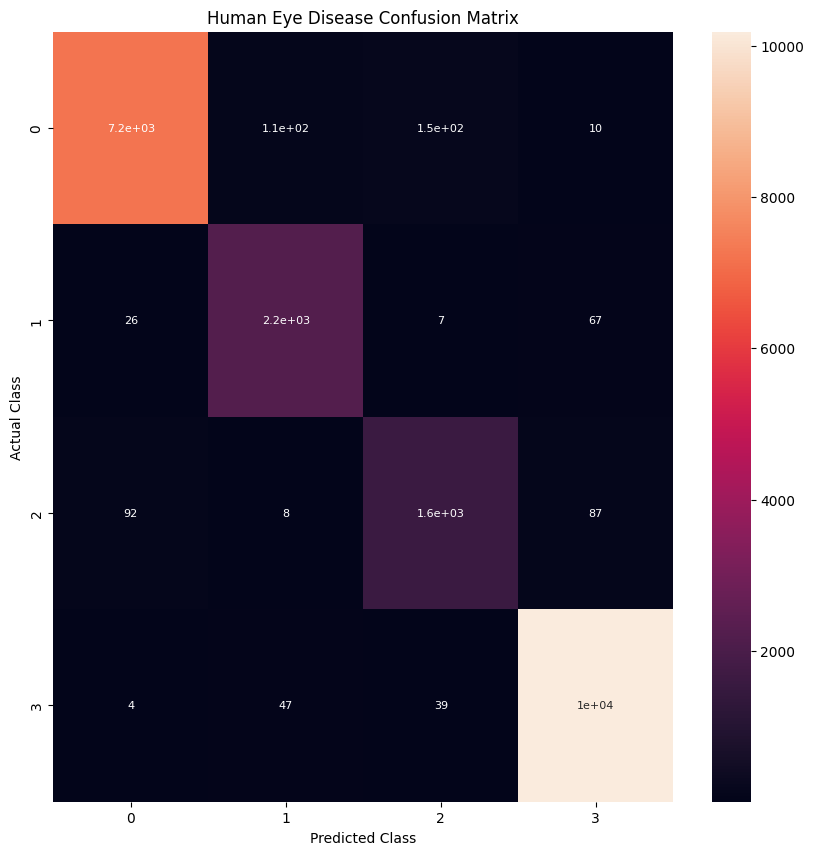

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, annot_kws={'size':8})
plt.xlabel('Predicted Class', fontsize=10)
plt.ylabel('Actual Class', fontsize=10)
plt.title('Human Eye Disease Confusion Matrix', fontsize=12)
plt.show()